<a href="https://colab.research.google.com/github/emreer94/COVID-19_Image_Generation/blob/main/dcgan_ft1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# File Location

In [ ]:
#Show your path
path="/content/drive/MyDrive/covidpos_dataset"

# Prepare the Data

In [ ]:
#Dataset formed containing 3615 COVID-19 CXR images and resize to 128x128
dataset = keras.preprocessing.image_dataset_from_directory(
    path, label_mode=None, image_size=(128, 128), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0) #Create the dataset and rescale the images to [0-1] range

Found 3615 files belonging to 1 classes.


(32, 128, 128, 3)


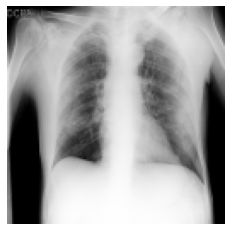

In [ ]:
#Display a sample image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    print(x.shape)
    break

# Discriminator

In [ ]:
#Map a 128x128 image to a binary classification score
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       1048832   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)           

# Generator

In [ ]:
#Mirror the discriminator by replacing Conv2D layers with Conv2DTranspose layers
latent_dim = 256

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 256),
        layers.Reshape((16, 16, 256)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       1048832   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 512)       2097664   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1024)    83

# Override `train_step`

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Callback that periodically saves generated images

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=256):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/generated_images_ft4/generated_img_%03d_%d.png" % (epoch, i)) #Save generated images into this path

# Train the end-to-end model

In [ ]:
epochs = 50 # Increase the epochs for better results

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
#Plot the evaluation results
plt.plot(r.history['loss_fn'], label='d_loss')
plt.plot(r.history['loss_fn'], label='g_loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

Epoch 1/30
113/113 [==============================] - 1777s 15s/step - d_loss: 0.2165 - g_loss: 5.5575
Epoch 2/30
113/113 [==============================] - 447s 4s/step - d_loss: 0.4633 - g_loss: 2.5931
Epoch 3/30
113/113 [==============================] - 448s 4s/step - d_loss: 0.5775 - g_loss: 2.4682
Epoch 4/30
113/113 [==============================] - 448s 4s/step - d_loss: 0.5915 - g_loss: 2.2990
Epoch 5/30
113/113 [==============================] - 448s 4s/step - d_loss: 0.6179 - g_loss: 1.5734
Epoch 6/30
113/113 [==============================] - 449s 4s/step - d_loss: 0.7934 - g_loss: 1.5112
Epoch 7/30
113/113 [==============================] - 448s 4s/step - d_loss: 0.5122 - g_loss: 1.6876
Epoch 8/30
113/113 [==============================] - 449s 4s/step - d_loss: 0.7798 - g_loss: 1.3131
Epoch 9/30
113/113 [==============================] - 448s 4s/step - d_loss: 0.5941 - g_loss: 1.5318
Epoch 10/30
113/113 [==============================] - 449s 4s/step - d_loss: 0.7969 - g_

"plt.plot(r.history['loss_fn'], label='d_loss')\nplt.plot(r.history['loss_fn'], label='g_loss')\nplt.legend()\nplt.show()\nplt.savefig('LossVal_loss')"